# Import Packages

In [1]:
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import os
import numpy as np
from datetime import datetime

In [2]:
##Web scraping for SP500 companies
wiki_dfs= pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

SP500_df= wiki_dfs[0]
SP500_df.drop(['CIK'], axis=1, inplace=True)
print(SP500_df.head())

  Symbol             Security SEC filings             GICS Sector  \
0    MMM           3M Company     reports             Industrials   
1    ABT  Abbott Laboratories     reports             Health Care   
2   ABBV          AbbVie Inc.     reports             Health Care   
3   ABMD          ABIOMED Inc     reports             Health Care   
4    ACN        Accenture plc     reports  Information Technology   

                GICS Sub-Industry    Headquarters Location Date first added  \
0        Industrial Conglomerates      St. Paul, Minnesota       1976-08-09   
1           Health Care Equipment  North Chicago, Illinois       1964-03-31   
2                 Pharmaceuticals  North Chicago, Illinois       2012-12-31   
3           Health Care Equipment   Danvers, Massachusetts       2018-05-31   
4  IT Consulting & Other Services          Dublin, Ireland       2011-07-06   

       Founded  
0         1902  
1         1888  
2  2013 (1888)  
3         1981  
4         1989  


In [3]:
SP500_tickers= SP500_df['Symbol']
print(SP500_tickers.head())

0     MMM
1     ABT
2    ABBV
3    ABMD
4     ACN
Name: Symbol, dtype: object


# Function to download Stocks Historical data from Yahoo Finance

In [155]:
def get_data_SP():
    if not os.path.exists('sp500_stocks'):
        os.makedirs('sp500_stocks')
     
        
    start= dt.datetime(2005, 1, 1)
    end= dt.datetime.now()
    
    for ticker in SP500_tickers:
          
         try:
             mtime= os.path.getmtime('sp500_stocks/{}.csv'.format(ticker))
         except OSError:
             mtime=0
         
         file_datem= dt.datetime.fromtimestamp(mtime)
    
     
         if (end-file_datem).days > 3:

              try:
                df= web.DataReader(ticker,'yahoo', start, end,)
                df.reset_index(inplace=True)
                df.set_index('Date', inplace=True)
                df.to_csv('sp500_stocks/{}.csv'.format(ticker))
              except Exception as ex:
                 print('Error:', ex)            
         else:
              print('Already have {}'.format(ticker))
        
     
            
get_data_SP()

Error: 'Date'
Error: 'Date'


# Create a single dataframe from all the Stock csv files

In [4]:
start= dt.datetime(2005, 1, 1)
end= dt.datetime.now()
dfIndex= pd.bdate_range(start, end)
SP_df=pd.DataFrame(index=dfIndex)
col=['Date','Adj Close']

import glob
path= r'C:\Users\valen\sp500_stocks'
all_files= glob.glob(path+ '/*.csv')

for file in all_files:
    pathf= os.path.basename(file)
    filename, file_extension= os.path.splitext(pathf)
    df= pd.read_csv(file, usecols=col, index_col='Date')
    df.columns=[filename]
    SP_df= SP_df.join(df, how='left')
    
   
    
print(SP_df.tail())

             A  AAL  AAP  AAPL  ABBV  ABC  ABMD  ABT  ACN  ADBE  ...  XLNX  \
2021-02-03 NaN  NaN  NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN  ...   NaN   
2021-02-04 NaN  NaN  NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN  ...   NaN   
2021-02-05 NaN  NaN  NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN  ...   NaN   
2021-02-08 NaN  NaN  NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN  ...   NaN   
2021-02-09 NaN  NaN  NaN   NaN   NaN  NaN   NaN  NaN  NaN   NaN  ...   NaN   

            XOM  XRAY  XRX  XYL  YUM  ZBH  ZBRA  ZION  ZTS  
2021-02-03  NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2021-02-04  NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2021-02-05  NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2021-02-08  NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  
2021-02-09  NaN   NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  

[5 rows x 504 columns]


# PCA & Absorption RatioCalculation on 3 month windows

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

daterange= pd.date_range(start=start, end= end, freq= pd.offsets.MonthBegin(2))
 
absorption_rate=[]

for sdate in daterange:
    
   
    end1= sdate + pd.offsets.MonthEnd(2)
    absratio= SP_df.loc[sdate:end1]
    
    mxnum_ns=10
    absratio= absratio.loc[:, (absratio.isnull().sum(axis=0)< mxnum_ns)].fillna(method='ffill')
    
   
    AR_ret= absratio.apply(np.log).diff(1).dropna()
    
    
        
    pclist=list=[f'PC{i}' for i in range(1,21)]
    col_name= AR_ret.columns
    if len(AR_ret)>30:
        pca= PCA(n_components=20)
        pc= pca.fit_transform(AR_ret)

        eigenvectors= pd.DataFrame(pca.components_.T,columns=pclist, index=col_name)
        sum_var_ev= pca.explained_variance_.sum()
        sum_var_ast= AR_ret.var(axis=0).sum()
        absorption_ratio= sum_var_ev/sum_var_ast
        absorption_rate.append([end1,absorption_ratio])
    else:
        print('Not enough data point in the last time window')

    
    
### 

AR_df= pd.DataFrame(absorption_rate,columns=['Date','Absorption ratio'])
print(AR_df.tail(10))

Not enough data point in the last time window
         Date  Absorption ratio
86 2019-06-30          0.840218
87 2019-08-31          0.864344
88 2019-10-31          0.846232
89 2019-12-31          0.833381
90 2020-02-29          0.869001
91 2020-04-30          0.954758
92 2020-06-30          0.917121
93 2020-08-31          0.848562
94 2020-10-31          0.869253
95 2020-12-31          0.906841


# Graphs

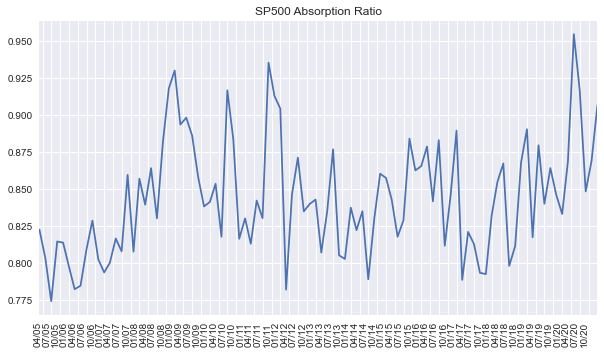

In [9]:
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.dates import DateFormatter, DayLocator, MonthLocator
from matplotlib.font_manager import FontProperties

###Absorption ratio
AR_df= pd.DataFrame(absorption_rate,columns=['Date','Absorption ratio'])

plt.rc('font', size=10)
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(AR_df['Date'], AR_df['Absorption ratio'])
ax.xaxis.set_major_formatter(DateFormatter('%m/%y'))
ax.xaxis.set_major_locator(MonthLocator(interval=3))
min_date=min(AR_df['Date'])
max_date=max(AR_df['Date'])
ax.set_xlim(min_date, max_date)
ax.set_title('SP500 Absorption Ratio')
fig.autofmt_xdate(rotation=90)

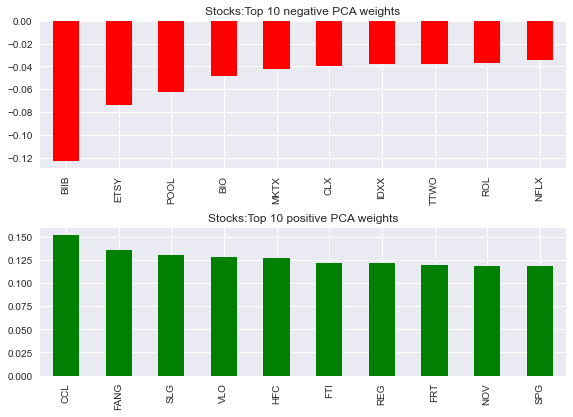

In [10]:
###PCA weights
pc1= eigenvectors.PC1

plt.rc('font', size=10)
plt.style.use('seaborn')
fig, ax = plt.subplots(2,1)
fig.tight_layout(h_pad=4)
pc1.nsmallest(10).plot.bar(ax=ax[0], color='red',
                           title='Stocks:Top 10 negative PCA weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='green',
                           title='Stocks:Top 10 positive PCA weights')


               GICS Sector       PC1
4               Financials  2.971271
3                   Energy  2.140273
6              Industrials  1.848851
1   Consumer Discretionary  1.512451
9              Real Estate  1.283147
7   Information Technology  0.760369
8                Materials  0.747863
10               Utilities  0.515137
0   Communication Services  0.403669
5              Health Care  0.312750
2         Consumer Staples  0.186454
                             neg       pos
GICS Sector                               
Communication Services -0.150115  0.553783
Consumer Discretionary -0.433615  1.946065
Consumer Staples       -0.203032  0.389487
Energy                  0.000000  2.140273
Financials             -0.146376  3.117647
Health Care            -0.484792  0.797542
Industrials            -0.127242  1.976093
Information Technology -0.303712  1.064081
Materials              -0.036613  0.784475
Real Estate            -0.155258  1.438405
Utilities               0.000000  0.5151

Text(0.5, 1.0, 'PCA weights by Sector')

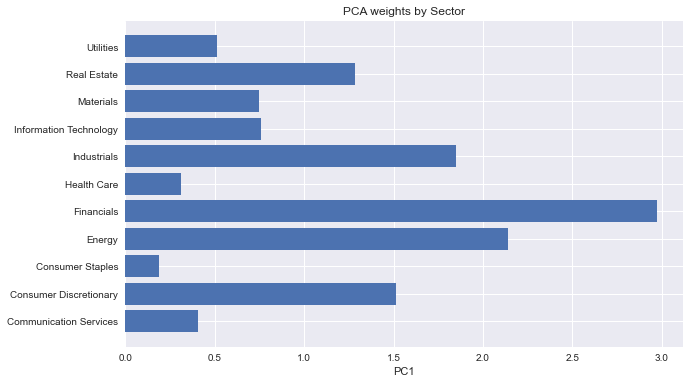

In [11]:
SP500_info=SP500_df.set_index('Symbol')
pc1df= pc1.to_frame()
mdf= pc1df.merge(SP500_info, left_index=True, right_index=True)
#ndf= pd.concat([pc1,dfSP500], axis=1)
sumsectorpc=mdf.groupby(['GICS Sector']).sum().reset_index()
print(sumsectorpc.sort_values('PC1', ascending=False))

sum_pos_neg=mdf.groupby(['GICS Sector'])['PC1'].agg([('neg', lambda x: x[x<0].sum()),('pos', lambda x: x[x>0].sum())])
print(sum_pos_neg)

plt.rc('font', size=10)
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(10,6))
ax.barh(sumsectorpc['GICS Sector'],sumsectorpc['PC1'])
ax.grid(True)
ax.set_xlabel('PC1')
ax.set_title('PCA weights by Sector')